In [381]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as funct
import gymnasium as gym
import numpy as np
from matplotlib import pyplot as plt
import numpy as np
from time import sleep
from IPython import display
import copy
from itertools import count
import operator

In [382]:
#Just to get rid of annoying warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=np.VisibleDeprecationWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [383]:
env = gym.make("CartPole-v1")

In [384]:
#plot the result (score after episodes)
#blue: score per episode
#red: mean score for the last n episodes
def plot(scores, ylabel = "Fitness of the best individual"):
    plt.plot(scores, color="r")
    plt.xlabel("Episode")
    plt.ylabel("Fitness of the best individual")
    plt.show()

In [385]:
class NN(nn.Module):
    """A Feed Forward Neural Network used for Deep-Q-Learning to solve the cartpole problem."""
    def __init__(self, obs_dim = env.observation_space.shape, n_actions = env.action_space.n):
        super(NN, self).__init__()      
        # The input (an observation/a state) has shape (4,) [cart pos, cart vel, pole angle, pole angular vel]
        self.fc1 = nn.Linear(*obs_dim, 128) # * to convert tuple (4,) to 4
        self.fc21 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, n_actions) # n_actions == 2

        self.optimizer = optim.Adam(self.parameters(), lr=1e-4)
        self.loss = nn.MSELoss()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

    def forward(self, x):
        x = funct.relu(self.fc1(x))
        x = funct.relu(self.fc21(x))
        return self.fc3(x)

In [386]:
class Agent():
    # represents the agent of the RL
    def __init__(self, obs_dim = env.observation_space.shape, n_actions = env.action_space.n, 
                 eps = 0.05, popSize=20):
        
        self.obs_dim = obs_dim
        self.n_actions = n_actions
        self.action_space = [i for i in range(n_actions)]
        self.eps = eps
        self.popSize = popSize
        self.population = [(NN(),0) for _ in range(self.popSize)]

    def pick_action(self, state, nn):
        if np.random.random() > self.eps:
            actions = nn.forward(state) 
            action =  torch.argmax(actions).item()
        else:
            action = np.random.choice(self.action_space)
        return action
    
    def train(self, max_iter, crossover, reps):
        iter = 0
        scores = []
        self.population = self.fitness(reps=reps,pop=self.population)
        while iter < max_iter and self.population[0][1] < 450:
            children = self.reprod(crossover=crossover)
            self.mutation(children)
            children = self.fitness(reps=reps, pop=children)
            self.population.extend(children)
            self.selection()
            iter += 1
            scores.append(self.population[0][1])
            display.clear_output()
            plot(scores=scores)

    def fitness(self, reps, pop):
        new_pop = []
        for p in pop:
            sum = 0
            for _ in range(reps):
                sum += self.play(p[0])
            new_pop.append((p[0],sum/reps))
        return new_pop
    
    def selection(self):
        """Elitist Selection"""
        sortedPop = sorted(self.population, key=operator.itemgetter(1), reverse=True)
        self.population = sortedPop[:self.popSize]

    def mutation(self, children):
        for c in children:
            nn = c[0]
            nn.fc1.weight = torch.nn.Parameter(nn.fc1.weight.add(torch.Tensor(np.random.normal(size=np.shape(nn.fc1.weight)))))
            nn.fc21.weight = torch.nn.Parameter(nn.fc21.weight.add(torch.Tensor(np.random.normal(size=np.shape(nn.fc21.weight)))))
            nn.fc3.weight = torch.nn.Parameter(nn.fc3.weight.add(torch.Tensor(np.random.normal(size=np.shape(nn.fc3.weight)))))

    def reprod(self, crossover = False):

        new = []
        for nn in self.population:
            new.append(copy.deepcopy(nn))

        if crossover:
            for i in range(0,self.popSize,2):
                nn1 = new[i][0]
                nn2 = new[i+1][0]
                
                for x in range(np.shape(nn1.fc1.weight)[0]):
                    for y in range(np.shape(nn1.fc1.weight)[1]):
                        if np.random.sample() > 0.5:
                            tmp = copy.deepcopy(copy.copy(nn1.fc1.weight[x][y])) #deepcopy isn't supported, so we have to copy first
                            nn1.fc1.weight.data[x][y] = nn2.fc1.weight[x][y]
                            nn2.fc1.weight.data[x][y] = tmp

                for x in range(np.shape(nn1.fc21.weight)[0]):
                    for y in range(np.shape(nn1.fc21.weight)[1]):
                        if np.random.sample() > 0.5:
                            tmp = copy.deepcopy(copy.copy(nn1.fc21.weight[x][y])) #deepcopy isn't supported, so we have to copy first
                            nn1.fc21.weight.data[x][y] = nn2.fc21.weight[x][y]
                            nn2.fc21.weight.data[x][y] = tmp

                for x in range(np.shape(nn1.fc3.weight)[0]):
                    for y in range(np.shape(nn1.fc3.weight)[1]):
                        if np.random.sample() > 0.5:
                            tmp = copy.deepcopy(copy.copy(nn1.fc3.weight[x][y])) #deepcopy isn't supported, so we have to copy first
                            nn1.fc3.weight.data[x][y] = nn2.fc3.weight[x][y]
                            nn2.fc3.weight.data[x][y] = tmp
            
        return new

    def play(self, nn: NN):
        obs, _ = env.reset()
        obs = torch.tensor(obs, dtype=torch.float, device=nn.device)
        score = 0
        terminated = False
        truncated = False
        while not terminated and not truncated:
            action = self.pick_action(obs, nn)
            obs_, reward, terminated, truncated, _ = env.step(action)
            obs = torch.tensor(obs_, dtype=torch.float, device=nn.device)
            score += 1
        return score
            

In [387]:
agent = Agent(popSize=20)

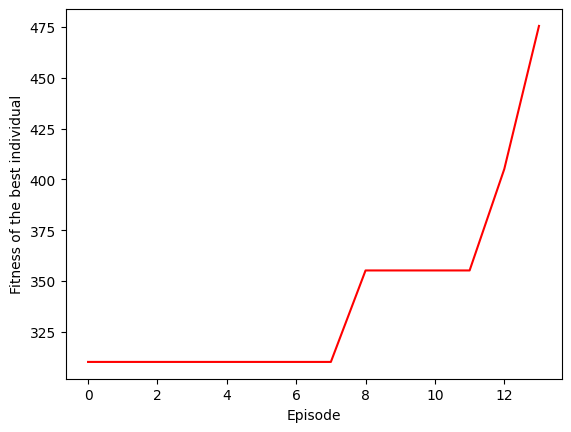

In [388]:
agent.train(max_iter=50, crossover=False, reps=10)

In [389]:
#env.close()
#env = gym.make("CartPole-v1", render_mode="human")

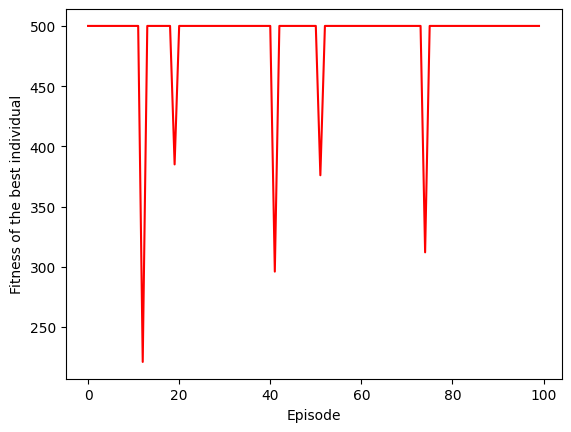

AVG Score after 100 games: 490.9


In [390]:
sum = 0
scores = []
for i in range(100):
    scores.append(agent.play(agent.population[0][0]))
    display.clear_output()
    plot(scores=scores,ylabel="Scores")

print("AVG Score after 100 games: " + str(np.sum(scores)/100))